**Общая информация**

**Срок сдачи:** 21 октября 2019, 08:30 

**Штраф за опоздание:** по 0.5 балла за 24 часа задержки. Через 10 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0919, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Невыполнение PEP8 -0.5 баллов
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [360]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.neighbors import KDTree
from sklearn.model_selection import cross_val_score


##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

In [429]:


class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin, ClassifierMixin):
    def __init__(self, n_neighbors, algorithm='brute', metric="euclidean"):
        self.algorithm = algorithm
        self.n_neighbors = n_neighbors
        self.metric = metric
        
    
    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        self.unique = np.unique(y).shape[0]
        if self.algorithm == "kd_tree":
            self.tree = KDTree(X)
    
    def predict(self, X):
        X = np.array(X)
        if self.algorithm == 'brute':
            dist = metrics.pairwise_distances(X, self.X_train, metric=self.metric)
            n_minimal_neighbors = self.y_train[np.argpartition(dist, self.n_neighbors)[:,0:self.n_neighbors]]
            
            y_res = []
            for i in range(X.shape[0]):
                neigh_and_count_in_str = np.unique(n_minimal_neighbors[i],return_counts=True)
                y_res.append(neigh_and_count_in_str[0][neigh_and_count_in_str[1].argmax()])
            
                
            y_res = np.array(y_res)
            return y_res
        
        elif self.algorithm == 'kd_tree':
            dist, indexes_of_neigh = self.tree.query(X, k=self.n_neighbors)        
            
            y_res = []
            for i in range(X.shape[0]):
                neigh_and_count_in_str = np.unique(self.y_train[indexes_of_neigh[i]], return_counts=True)
                y_res.append(neigh_and_count_in_str[0][neigh_and_count_in_str[1].argmax()])
            
            return np.array(y_res)
        
    
    def predict_proba(self, X):
        dist = metrics.pairwise_distances(X, self.X_train)
        n_minimal_neighbors = self.y_train[np.argpartition(dist, self.n_neighbors)[:,0:self.n_neighbors]]
        prob_res = np.array([np.bincount(n_minimal_neighbors[i], minlength=self.unique) for i in range(X.shape[0])])
        return prob_res / self.n_neighbors
        
    
    def score(self, X, y):
        X = np.array(X)
        y = np.array(y)
        return (np.isclose(self.predict(X), y)).sum() / y.shape[0]

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [362]:
iris = datasets.load_iris()

In [363]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [364]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [365]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [366]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy

In [367]:
%time clf.fit(X_train, y_train)

CPU times: user 562 µs, sys: 34 µs, total: 596 µs
Wall time: 412 µs


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [368]:
%time my_clf.fit(X_train, y_train)

CPU times: user 346 µs, sys: 21 µs, total: 367 µs
Wall time: 246 µs


In [369]:
%time clf.predict(X_test)

CPU times: user 7.53 ms, sys: 118 µs, total: 7.65 ms
Wall time: 4.95 ms


array([1, 2, 1, 1, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2, 1])

In [370]:
%time my_clf.predict(X_test)

CPU times: user 929 µs, sys: 3.56 ms, total: 4.49 ms
Wall time: 2.78 ms


array([1, 2, 1, 1, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2, 1])

In [371]:
%time clf.predict_proba(X_test)

CPU times: user 4.67 ms, sys: 54 µs, total: 4.73 ms
Wall time: 3.05 ms


array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [372]:
%time my_clf.predict_proba(X_test)

CPU times: user 4.32 ms, sys: 16 µs, total: 4.33 ms
Wall time: 2.42 ms


array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

In [373]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [374]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [375]:
%time clf.fit(X_train, y_train)

CPU times: user 0 ns, sys: 1.67 ms, total: 1.67 ms
Wall time: 9.24 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [376]:
%time my_clf.fit(X_train, y_train)

CPU times: user 180 µs, sys: 11 µs, total: 191 µs
Wall time: 166 µs


In [377]:
%time clf.predict(X_test)

CPU times: user 3.12 ms, sys: 3.8 ms, total: 6.92 ms
Wall time: 4.71 ms


array([2, 2, 1, 0, 0, 0, 1, 1, 2, 2, 2, 1, 0, 1, 0])

In [378]:
%time my_clf.predict(X_test)

CPU times: user 2.32 ms, sys: 141 µs, total: 2.46 ms
Wall time: 1.49 ms


array([2, 2, 1, 0, 0, 0, 1, 1, 2, 2, 2, 1, 0, 1, 0])

In [379]:
%time clf.predict_proba(X_test)

CPU times: user 3.56 ms, sys: 153 µs, total: 3.71 ms
Wall time: 2.64 ms


array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [380]:
%time my_clf.predict_proba(X_test)

CPU times: user 1.01 ms, sys: 0 ns, total: 1.01 ms
Wall time: 674 µs


array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [381]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [382]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [383]:
data = newsgroups['data']
target = newsgroups['target']


Переведите во всех документах все буквы в нижний регистр и замените во всех документах символы, не
являющиеся буквами и цифрами, на пробелы. Далее разбейте текста по пробельным символам на токены(термы/слова). Удалите текста, содержащие только пробелы.

In [384]:
len(data)

11314

In [385]:
data = [i.lower() for i in data]

In [386]:
%%time
#Кладём в data строки только из цифр, букв и пробелов 
for i in range(len(data)):
    res = ''
    for j in data[i]:
        num = ord(j)
        if not ((num >= 97 and num <= 122) or (num >= 48 and num <= 57)):
            res += " "
        else:
            res += j
    data[i] = res
    

CPU times: user 3.27 s, sys: 3.89 ms, total: 3.27 s
Wall time: 3.27 s


In [387]:

data_tok = []
target_tok = []

In [388]:
%%time
#Составляем список списков слов в каждом тексте
#и удаляем пустые тексты
for i in range(len(data)):
    res = []
    for j in data[i].split(" "):
        if j != "":
            res.append(j)
    if len(res) != 0:
        data_tok.append(res)
        target_tok.append(target[i])

CPU times: user 421 ms, sys: 16 ms, total: 437 ms
Wall time: 436 ms


In [389]:
assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l:l.islower() , map(' '.join, data_tok))), "please make sure that you lowercase the data and drop spaced texts"

Преобразуйте датасет в разреженную матрицу scipy.sparse.csr_matrix, где значение x в позиции (i, j)
означает, что в документе i слово j встретилось x раз

In [390]:
all_words = {}
words = []
numbers = []

In [391]:

# Создаём список всех слов во всех текстах

for i in data_tok:
    for j in i:
        all_words.setdefault(j, 0)
        all_words[j] += 1

        
words = list(all_words.keys())
numbers = list(all_words.values())


In [392]:
np.array(numbers)[np.where(np.array(numbers) < 10000)].shape

(98708,)

In [393]:
words = [words[i] for i in range(len(words)) if numbers[i] > 100]


In [394]:
len(words)

2427

In [395]:
rows = []
columns = []
data_new = []

In [396]:


words_in_i_text = dict.fromkeys(words, 0)
#print(words_in_i_text)
for i in range(len(data_tok)):
    words_in_i_text = {x:0 for x in words_in_i_text}
    
    for j in data_tok[i]:
        if j in words_in_i_text.keys():
            #print(j)
            words_in_i_text[j] += 1
    #print(np.unique(words_in_i_text.values()).shape)
    values = list(words_in_i_text.values())
    for j in range(len(words_in_i_text)):
        
        if(values[j] != 0):
            #print(j)
            rows.append(i)
            columns.append(j)
            data_new.append(values[j])

In [397]:
np.array(rows).shape

(779500,)

In [398]:
np.unique(columns).shape

(2427,)

In [399]:
np.array(data_new).shape

(779500,)

In [400]:
matrix = scipy.sparse.csr_matrix((data_new, (rows, columns)), shape=(len(data_tok), len(words)))

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [401]:
matrix.todense().shape

(11004, 2427)

In [402]:
f_x = []
x_ = []
for i in range(1, 30):
    x_.append(i)
    f_x.append(np.array(cross_val_score(MyKNeighborsClassifier(i), matrix.todense(), target_tok, cv=3)).mean())
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальный score в среднем на валидации на 3 фолдах).
Постройте график зависимости среднего score от количества соседей. Можно рассмотреть число соседей от 1 до 10.

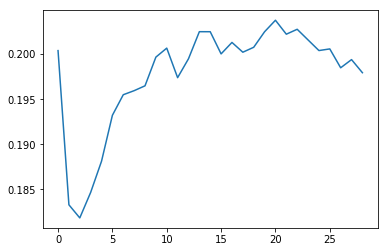

In [403]:

plt.plot(f_x)

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf преобразование( sklearn.feature_extraction.text.TfidfTransformer)

Сравните модели, выберите лучшую.

In [404]:
f_x = []
x_ = []
for i in range(1, 30):
    x_.append(i)
    f_x.append(np.array(cross_val_score(MyKNeighborsClassifier(i, metric="cosine"), matrix.todense(), target_tok, cv=3)).mean())
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


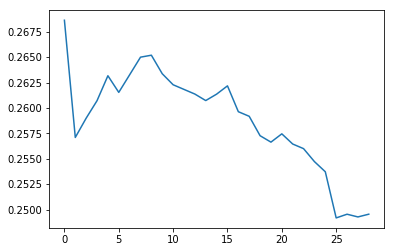

In [405]:

plt.plot(f_x)

In [406]:
cl = sklearn.feature_extraction.text.TfidfTransformer()
cl.fit(matrix, target_tok)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [407]:
mat1 = cl.transform(matrix)

In [408]:

f_x = []
x_ = []
for i in range(1, 30):
    x_.append(i)
    f_x.append(np.array(cross_val_score(MyKNeighborsClassifier(i, metric="cosine"), mat1.todense(), target_tok, cv=3)).mean())
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


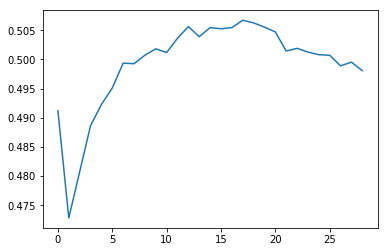

In [409]:

plt.plot(f_x)

In [410]:
f_x = []
x_ = []
for i in range(1, 30):
    x_.append(i)
    f_x.append(np.array(cross_val_score(MyKNeighborsClassifier(i), mat1.todense(), target_tok, cv=3)).mean())
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


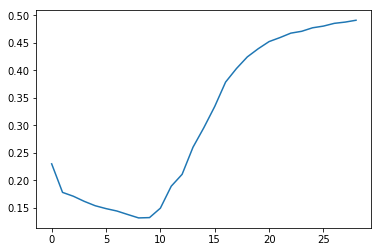

In [411]:
plt.plot(f_x)

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [412]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])
data_train = newsgroups['data']
target_train = newsgroups['target']
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])
data_test = newsgroups['data']
target_test = newsgroups['target']

In [413]:
data_train = [i.lower() for i in data_train]
data_test = [i.lower() for i in data_test]


In [414]:

for i in range(len(data_train)):
    res = ''
    for j in data_train[i]:
        num = ord(j)
        if not ((num >= 97 and num <= 122) or (num >= 48 and num <= 57)):
            res += " "
        else:
            res += j
    data_train[i] = res
    
for i in range(len(data_test)):
    res = ''
    for j in data_test[i]:
        num = ord(j)
        if not ((num >= 97 and num <= 122) or (num >= 48 and num <= 57)):
            res += " "
        else:
            res += j
    data_test[i] = res

In [415]:
data_train_tok = []
target_train_tok = []

In [416]:

for i in range(len(data_train)):
    res = []
    for j in data_train[i].split(" "):
        if j != "":
            res.append(j)
    if len(res) != 0:
        data_train_tok.append(res)
        target_train_tok.append(target_train[i])

In [417]:
data_test_tok = []
target_test_tok = []

In [418]:

for i in range(len(data_test)):
    res = []
    for j in data_test[i].split(" "):
        if j != "":
            res.append(j)
    if len(res) != 0:
        data_test_tok.append(res)
        target_test_tok.append(target_test[i])

In [419]:
all_words = {}# Make list of all words
for i in data_train_tok:
    for j in i:
        all_words.setdefault(j, 0)
        all_words[j] += 1
        
for i in data_test_tok:
    for j in i:
        all_words.setdefault(j, 0)
        all_words[j] += 1
words = list(all_words.keys())
numbers = list(all_words.values())

In [420]:
words = [words[i] for i in range(len(words)) if numbers[i] > 100]

In [421]:
rows = []
columns = []
data_train = []
words_in_i_text = dict.fromkeys(words, 0)
for i in range(len(data_train_tok)):
    words_in_i_text = {x:0 for x in words_in_i_text}
    
    for j in data_train_tok[i]:
        if j in words_in_i_text.keys():
            #print(j)
            words_in_i_text[j] += 1
        
    values = list(words_in_i_text.values())
    for j in range(len(words_in_i_text)):
        if(values[j] != 0):
            rows.append(i)
            columns.append(j)
            data_train.append(values[j])

In [422]:

matrix_train = scipy.sparse.csr_matrix((data_train, (rows, columns)), shape=(len(data_train_tok), len(all_words)))
cl = sklearn.feature_extraction.text.TfidfTransformer()
cl.fit(matrix_train, target_train_tok)
matrix_train = cl.transform(matrix_train)

In [423]:
rows = []
columns = []
data_test = []
words_in_i_text = dict.fromkeys(words, 0)
for i in range(len(data_test_tok)):
    words_in_i_text = {x:0 for x in words_in_i_text}
    
    for j in data_test_tok[i]:
        if j in words_in_i_text.keys():
            #print(j)
            words_in_i_text[j] += 1
        
    values = list(words_in_i_text.values())
    for j in range(len(words_in_i_text)):
        if(values[j] != 0):
            rows.append(i)
            columns.append(j)
            data_test.append(values[j])

In [424]:
matrix_test = scipy.sparse.csr_matrix((data_test, (rows, columns)), shape=(len(data_test_tok), len(all_words)))
cl = sklearn.feature_extraction.text.TfidfTransformer()
cl.fit(matrix_train, target_train_tok)
matrix_test = cl.transform(matrix_test)

In [425]:
scores = []
for i in range(1, 30):
    cl = KNeighborsClassifier(i)
    cl.fit(matrix_train, target_train_tok)
    s = cl.score(matrix_test, target_test_tok)
    scores.append(s)
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


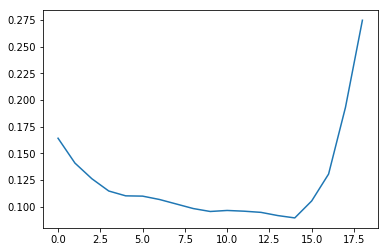

In [286]:
plt.plot(scores)

In [431]:
scores = []
for i in range(1, 30):
    cl = KNeighborsClassifier(i, metric="cosine")
    cl.fit(matrix_train, target_train_tok)
    s = cl.score(matrix_test, target_test_tok)
    scores.append(s)
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


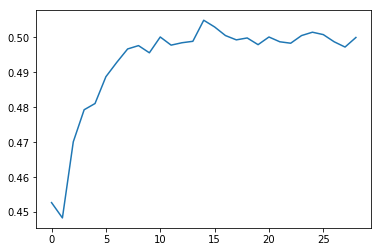

In [432]:
plt.plot(scores)

Оценим качество(score) вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [433]:
max(scores)

0.5048570255848953

Получили очень плохое качество. Проверим классы в тренировочной выборке и тестовой, вдруг в обеих выборках они разные

Попробуем обьединить тренировочную и тестовую выборки и оценим качество на валидации

In [343]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])
data_train = newsgroups['data']
target_train = newsgroups['target']
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])
data_test = newsgroups['data']
target_test = newsgroups['target']
data = data_train
data+=data_test

In [344]:
target = list(target_train)
target += list(target_test)

In [345]:
data = [i.lower() for i in data]

In [346]:
%%time
#Кладём в data строки только из цифр, букв и пробелов 
for i in range(len(data)):
    res = ''
    for j in data[i]:
        num = ord(j)
        if not ((num >= 97 and num <= 122) or (num >= 48 and num <= 57)):
            res += " "
        else:
            res += j
    data[i] = res
    

CPU times: user 5.12 s, sys: 161 µs, total: 5.12 s
Wall time: 5.12 s


In [347]:
%%time
data_tok = []
target_tok = []
#Составляем список списков слов в каждом тексте
#и удаляем пустые тексты
for i in range(len(data)):
    res = []
    for j in data[i].split(" "):
        if j != "":
            res.append(j)
    if len(res) != 0:
        data_tok.append(res)
        target_tok.append(target[i])

CPU times: user 892 ms, sys: 332 ms, total: 1.22 s
Wall time: 1.22 s


In [348]:
%%time
data_tok = []
target_tok = []
#Составляем список списков слов в каждом тексте
#и удаляем пустые тексты
for i in range(len(data)):
    res = []
    for j in data[i].split(" "):
        if j != "":
            res.append(j)
    if len(res) != 0:
        data_tok.append(res)
        target_tok.append(target[i])

CPU times: user 736 ms, sys: 16.2 ms, total: 752 ms
Wall time: 751 ms


In [349]:
%%time
# Создаём список всех слов во всех текстах
all_words = {}
for i in data_tok:
    for j in i:
        all_words.setdefault(j, 0)
        all_words[j] += 1
all_words = list(all_words.keys())

CPU times: user 497 ms, sys: 107 µs, total: 497 ms
Wall time: 498 ms


In [350]:
words = list(all_words.keys())
numbers = list(all_words.values())
words = [words[i] for i in range(len(words)) if numbers[i] > 100]

In [351]:
rows = []
columns = []
data_new = []

In [352]:
%%time

words_in_i_text = dict.fromkeys(words, 0)
for i in range(len(data_tok)):
    words_in_i_text = {x:0 for x in words_in_i_text}
    
    for j in data_tok[i]:
        if j in words_in_i_text.keys():
            words_in_i_text[j] += 1
        
    values = list(words_in_i_text.values())
    for j in range(len(words_in_i_text)):
        if(values[j] != 0):
            rows.append(i)
            columns.append(j)
            data_new.append(values[j])

CPU times: user 5.46 s, sys: 136 µs, total: 5.46 s
Wall time: 5.46 s


In [355]:
matrix = scipy.sparse.csr_matrix((data_new, (rows, columns)), shape=(len(data_tok), len(words)))

In [356]:
cl = sklearn.feature_extraction.text.TfidfTransformer()
cl.fit(matrix,target_tok)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [357]:
mat1 = cl.transform(matrix)
f_x = []
x_ = []
for i in range(1, 20):
    x_.append(i)
    f_x.append(np.array(cross_val_score(KNeighborsClassifier(i, metric="cosine"), mat1.todense(), target_tok, cv=3)).mean())
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


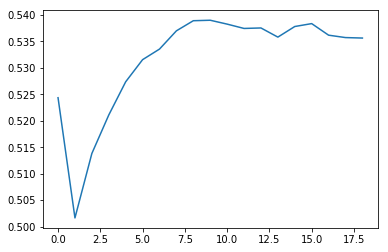

In [358]:
plt.plot(f_x)

Получили хоорошее качество, как в предыдущий раз

In [207]:
train_data = fetch_20newsgroups(subset='train')
test_data = fetch_20newsgroups(subset='test')

In [208]:
np.unique(train_data.target)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [209]:
np.unique(test_data.target)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [225]:
np.unique(train_data.target_names)

array(['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc',
       'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
       'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
       'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt',
       'sci.electronics', 'sci.med', 'sci.space',
       'soc.religion.christian', 'talk.politics.guns',
       'talk.politics.mideast', 'talk.politics.misc',
       'talk.religion.misc'], dtype='<U24')

In [226]:
np.unique(test_data.target_names)

array(['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc',
       'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
       'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
       'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt',
       'sci.electronics', 'sci.med', 'sci.space',
       'soc.religion.christian', 'talk.politics.guns',
       'talk.politics.mideast', 'talk.politics.misc',
       'talk.religion.misc'], dtype='<U24')